# Lab 4: Aholi o'sishi-kamayishi bo'yicha Decision Tree Regression

**Dataset:** World Development Indicators — Population growth (annual %)

**Qadamlar:**
1. Datasetni yuklash
2. Pipeline va Preprocessing
3. Matplotlib bilan vizualizatsiya
4. Decision Tree Regression modeli

## 1. Kutubxonalarni import qilish va datasetni yuklash

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Datasetni yuklash (birinchi 2 qator metadata, 3-qator header)
df = pd.read_csv('lab4.csv', skiprows=4)
print(f"Dataset shakli: {df.shape}")
df.head()

Dataset shakli: (266, 71)


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,Unnamed: 70
0,Aruba,ABW,Population growth (annual %),SP.POP.GROW,NaN,1.187344,1.326227,1.203664,1.076602,0.986114,...,0.007358,0.158976,0.270505,-0.565684,-0.820211,-0.362774,0.045652,0.590657,NaN,NaN
1,Africa Eastern and Southern,AFE,Population growth (annual %),SP.POP.GROW,NaN,2.624624,2.687009,2.714042,2.769856,2.809882,...,2.642067,2.734263,2.721681,2.699516,2.649439,2.592754,2.519167,2.472801,NaN,NaN
2,Afghanistan,AFG,Population growth (annual %),SP.POP.GROW,NaN,1.962239,2.044523,2.105208,2.161195,2.233709,...,2.808337,2.910810,2.984389,3.153609,2.356098,1.435704,2.135594,2.836573,NaN,NaN
3,Africa Western and Central,AFW,Population growth (annual %),SP.POP.GROW,NaN,2.103832,2.131522,2.170015,2.184894,2.216283,...,2.626296,2.533621,2.440048,2.389176,2.363829,2.332270,2.386204,2.398473,NaN,NaN
4,Angola,AGO,Population growth (annual %),SP.POP.GROW,NaN,1.327797,0.989639,1.003666,1.027684,1.052133,...,3.540612,3.453233,3.387884,3.267959,3.181323,3.143026,3.080655,3.044200,NaN,NaN


## 2. Preprocessing va Pipeline

In [2]:
# Keraksiz ustunlarni olib tashlash
df = df.drop(columns=['Indicator Name', 'Indicator Code'], errors='ignore')

# Oxirgi bo'sh ustunni olib tashlash (agar mavjud bo'lsa)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Bo'sh qatorlarni olib tashlash
df = df.dropna(how='all')

print(f"Tozalangandan keyin: {df.shape}")
df.head()

Tozalangandan keyin: (266, 68)


,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
0,Aruba,ABW,NaN,1.187344,1.326227,1.203664,1.076602,0.986114,0.862399,0.503043,...,0.757968,0.007358,0.158976,0.270505,-0.565684,-0.820211,-0.362774,0.045652,0.590657,NaN
1,Africa Eastern and Southern,AFE,NaN,2.624624,2.687009,2.714042,2.769856,2.809882,2.810324,2.844811,...,2.640743,2.642067,2.734263,2.721681,2.699516,2.649439,2.592754,2.519167,2.472801,NaN
2,Afghanistan,AFG,NaN,1.962239,2.044523,2.105208,2.161195,2.233709,2.269651,2.306668,...,2.535720,2.808337,2.910810,2.984389,3.153609,2.356098,1.435704,2.135594,2.836573,NaN
3,Africa Western and Central,AFW,NaN,2.103832,2.131522,2.170015,2.184894,2.216283,2.249277,2.264622,...,2.672913,2.626296,2.533621,2.440048,2.389176,2.363829,2.332270,2.386204,2.398473,NaN
4,Angola,AGO,NaN,1.327797,0.989639,1.003666,1.027684,1.052133,1.070046,1.076727,...,3.576441,3.540612,3.453233,3.387884,3.267959,3.181323,3.143026,3.080655,3.044200,NaN


In [3]:
# Ma'lumotlarni "wide" formatdan "long" formatga o'tkazish (melt)
year_columns = [col for col in df.columns if col.isdigit()]

df_long = df.melt(
    id_vars=['Country Name', 'Country Code'],
    value_vars=year_columns,
    var_name='Year',
    value_name='Population_Growth'
)

df_long['Year'] = df_long['Year'].astype(int)
df_long['Population_Growth'] = pd.to_numeric(df_long['Population_Growth'], errors='coerce')

print(f"Long format: {df_long.shape}")
df_long.head(10)

Long format: (17556, 4)


,Country Name,Country Code,Year,Population_Growth
0,Aruba,ABW,1960,NaN
1,Africa Eastern and Southern,AFE,1960,NaN
2,Afghanistan,AFG,1960,NaN
3,Africa Western and Central,AFW,1960,NaN
4,Angola,AGO,1960,NaN
5,Albania,ALB,1960,NaN
6,Andorra,AND,1960,NaN
7,Arab World,ARB,1960,NaN
8,United Arab Emirates,ARE,1960,NaN
9,Argentina,ARG,1960,NaN


In [4]:
# Bo'sh qiymatlar tahlili
print("Bo'sh qiymatlar soni:")
print(df_long.isnull().sum())
print(f"\nUmumiy qatorlar: {len(df_long)}")
print(f"Bo'sh Population_Growth: {df_long['Population_Growth'].isnull().sum()}")
print(f"Bo'sh qiymatlar ulushi: {df_long['Population_Growth'].isnull().mean():.2%}")

Bo'sh qiymatlar soni:
Country Name           0
Country Code           0
Year                   0
Population_Growth    628
dtype: int64

Umumiy qatorlar: 17556
Bo'sh Population_Growth: 628
Bo'sh qiymatlar ulushi: 3.58%


In [5]:
# Bo'sh qiymatlarni olib tashlash
df_clean = df_long.dropna(subset=['Population_Growth']).reset_index(drop=True)

print(f"Tozalangan dataset: {df_clean.shape}")
print(f"\nDavlatlar soni: {df_clean['Country Name'].nunique()}")
print(f"Yillar diapazoni: {df_clean['Year'].min()} - {df_clean['Year'].max()}")
df_clean.describe()

Tozalangan dataset: (16928, 4)

Davlatlar soni: 265
Yillar diapazoni: 1961 - 2024


,Year,Population_Growth
count,16928.000000,16928.000000
mean,1992.528474,1.732333
std,18.472086,1.675854
min,1961.000000,-27.470786
25%,1977.000000,0.727127
50%,1993.000000,1.702535
75%,2009.000000,2.615780
max,2024.000000,21.700343


In [6]:
# LabelEncoder — davlat nomlarini raqamga kodlash
le = LabelEncoder()
df_clean['Country_Encoded'] = le.fit_transform(df_clean['Country Name'])

print("Kodlangan ustunlar:")
df_clean[['Country Name', 'Country_Encoded', 'Year', 'Population_Growth']].head(10)

Kodlangan ustunlar:


,Country Name,Country_Encoded,Year,Population_Growth
0,Aruba,12,1961,1.187344
1,Africa Eastern and Southern,1,1961,2.624624
2,Afghanistan,0,1961,1.962239
3,Africa Western and Central,2,1961,2.103832
4,Angola,7,1961,1.327797
5,Albania,3,1961,3.120855
6,Andorra,6,1961,7.814817
7,Arab World,9,1961,2.578239
8,United Arab Emirates,250,1961,4.943028
9,Argentina,10,1961,1.655167


## 3. Vizualizatsiya (Matplotlib)

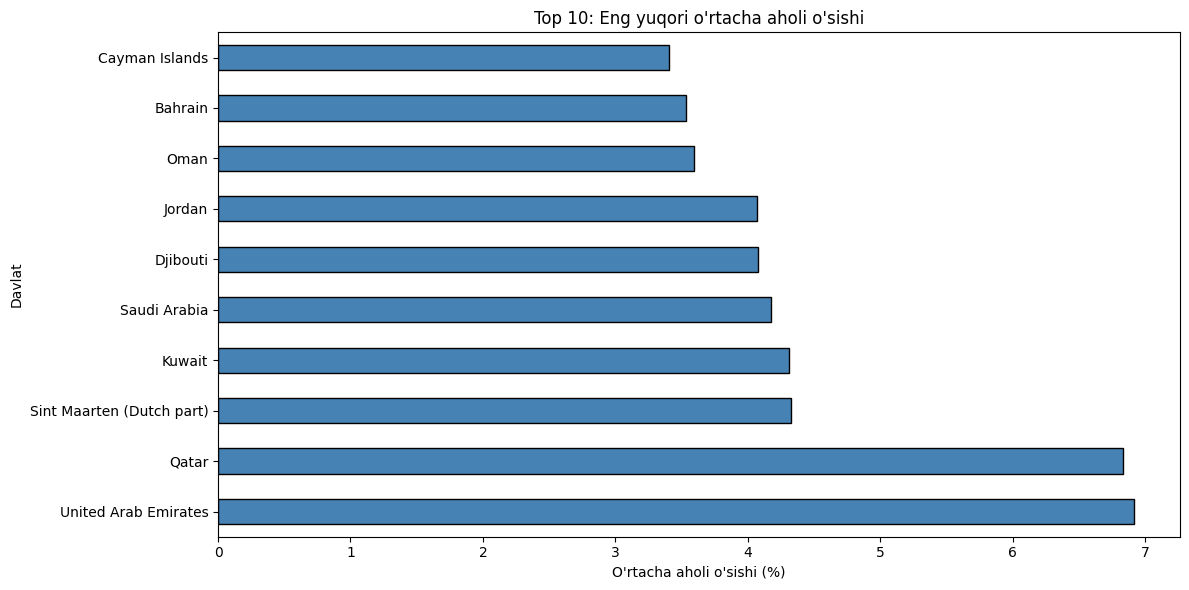

In [7]:
# Top 10 eng yuqori o'rtacha aholi o'sishiga ega davlatlar
top10 = df_clean.groupby('Country Name')['Population_Growth'].mean().nlargest(10)

plt.figure(figsize=(12, 6))
top10.plot(kind='barh', color='steelblue', edgecolor='black')
plt.xlabel('O\'rtacha aholi o\'sishi (%)')
plt.ylabel('Davlat')
plt.title('Top 10: Eng yuqori o\'rtacha aholi o\'sishi')
plt.tight_layout()
plt.show()

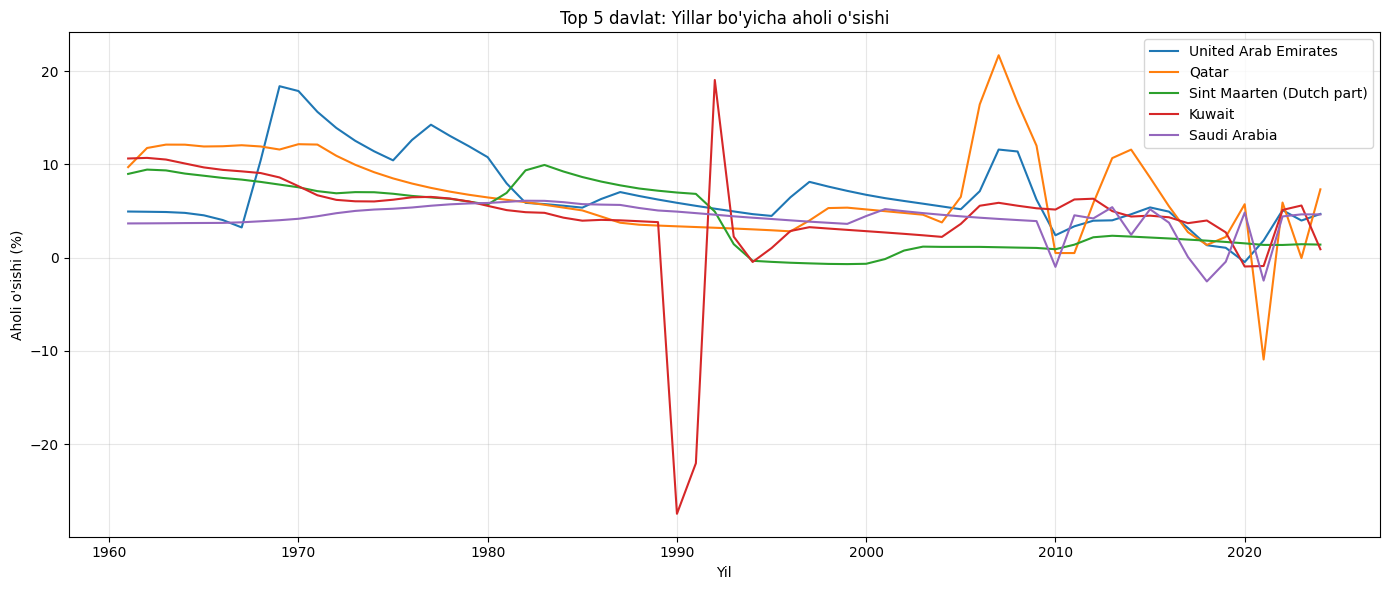

In [8]:
# Top 5 davlat uchun yillar bo'yicha aholi o'sishi
top5_countries = df_clean.groupby('Country Name')['Population_Growth'].mean().nlargest(5).index

plt.figure(figsize=(14, 6))
for country in top5_countries:
    data = df_clean[df_clean['Country Name'] == country]
    plt.plot(data['Year'], data['Population_Growth'], label=country, linewidth=1.5)

plt.xlabel('Yil')
plt.ylabel('Aholi o\'sishi (%)')
plt.title('Top 5 davlat: Yillar bo\'yicha aholi o\'sishi')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

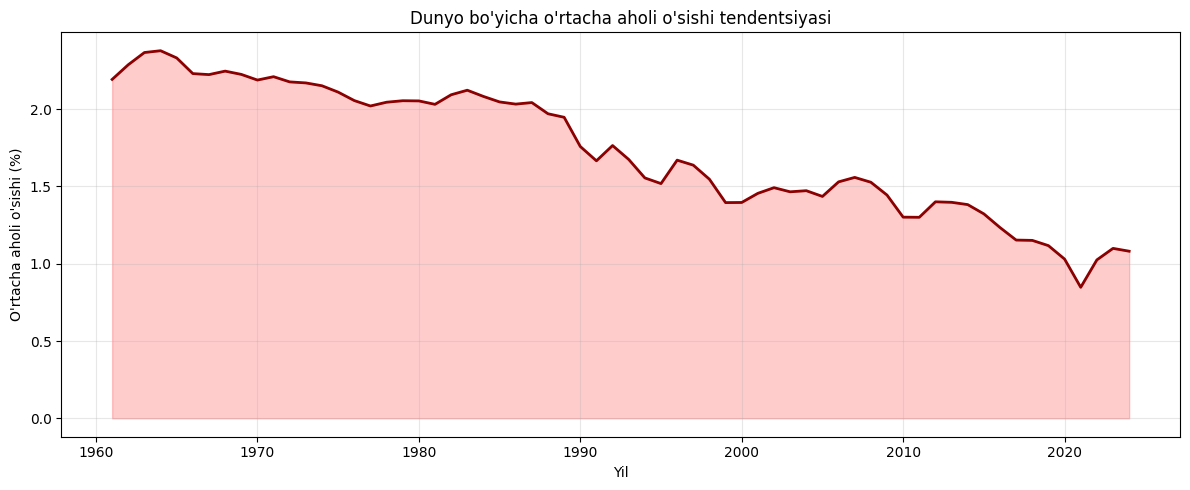

In [9]:
# Dunyo bo'yicha o'rtacha aholi o'sishi tendentsiyasi
world_avg = df_clean.groupby('Year')['Population_Growth'].mean()

plt.figure(figsize=(12, 5))
plt.plot(world_avg.index, world_avg.values, color='darkred', linewidth=2)
plt.fill_between(world_avg.index, world_avg.values, alpha=0.2, color='red')
plt.xlabel('Yil')
plt.ylabel('O\'rtacha aholi o\'sishi (%)')
plt.title('Dunyo bo\'yicha o\'rtacha aholi o\'sishi tendentsiyasi')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

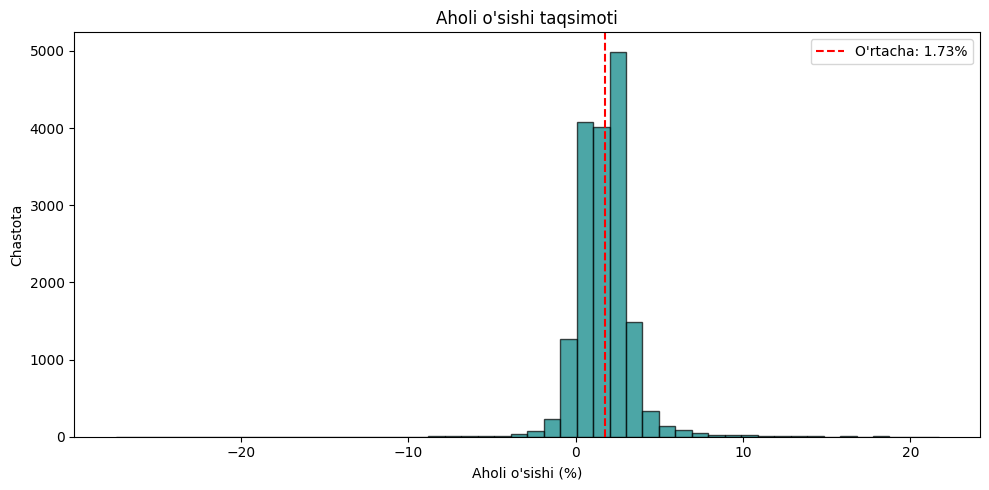

In [10]:
# Population Growth taqsimoti (histogram)
plt.figure(figsize=(10, 5))
plt.hist(df_clean['Population_Growth'], bins=50, color='teal', edgecolor='black', alpha=0.7)
plt.axvline(df_clean['Population_Growth'].mean(), color='red', linestyle='--', label=f'O\'rtacha: {df_clean["Population_Growth"].mean():.2f}%')
plt.xlabel('Aholi o\'sishi (%)')
plt.ylabel('Chastota')
plt.title('Aholi o\'sishi taqsimoti')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Decision Tree Regression

In [11]:
# Feature va targetni ajratish
X = df_clean[['Country_Encoded', 'Year']]
y = df_clean['Population_Growth']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (13542, 2), Test: (3386, 2)


In [12]:
# Pipeline: Imputer + Scaler + DecisionTreeRegressor
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=42))
])

# Modelni o'qitish
pipeline.fit(X_train, y_train)

# Bashorat qilish
y_pred = pipeline.predict(X_test)

print("Model o'qitildi!")

Model o'qitildi!


In [13]:
# Natijalarni baholash
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=" * 45)
print("   Decision Tree Regression Natijalari")
print("=" * 45)
print(f"  MSE  (Mean Squared Error):    {mse:.4f}")
print(f"  RMSE (Root Mean Squared Error):{rmse:.4f}")
print(f"  MAE  (Mean Absolute Error):   {mae:.4f}")
print(f"  R2   (R-squared Score):        {r2:.4f}")
print("=" * 45)

   Decision Tree Regression Natijalari
  MSE  (Mean Squared Error):    1.8917
  RMSE (Root Mean Squared Error):1.3754
  MAE  (Mean Absolute Error):   0.8936
  R2   (R-squared Score):        0.2768


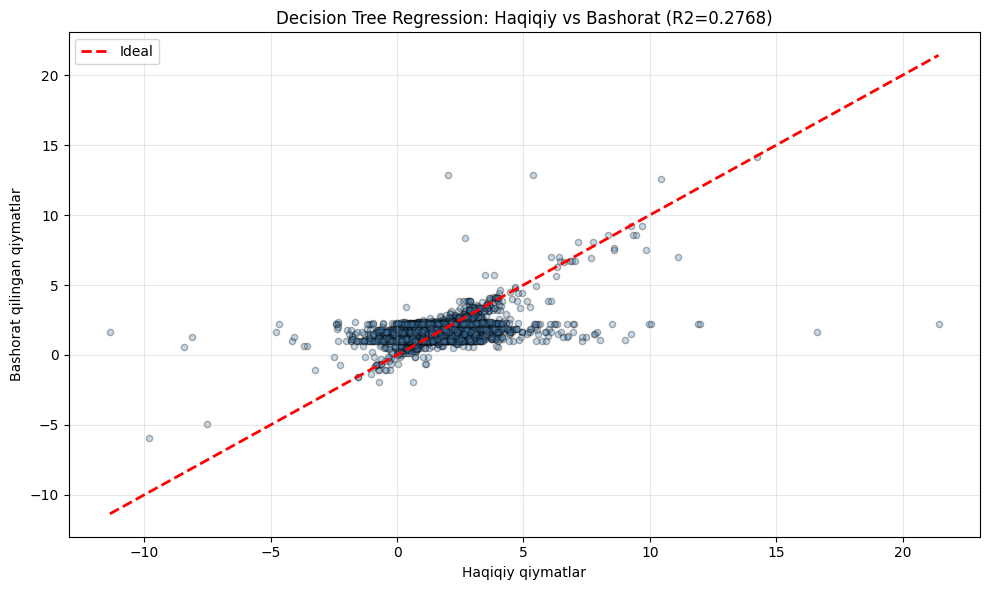

In [14]:
# Haqiqiy vs Bashorat qilingan qiymatlar
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='steelblue', edgecolor='k', s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Ideal')
plt.xlabel('Haqiqiy qiymatlar')
plt.ylabel('Bashorat qilingan qiymatlar')
plt.title(f'Decision Tree Regression: Haqiqiy vs Bashorat (R2={r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

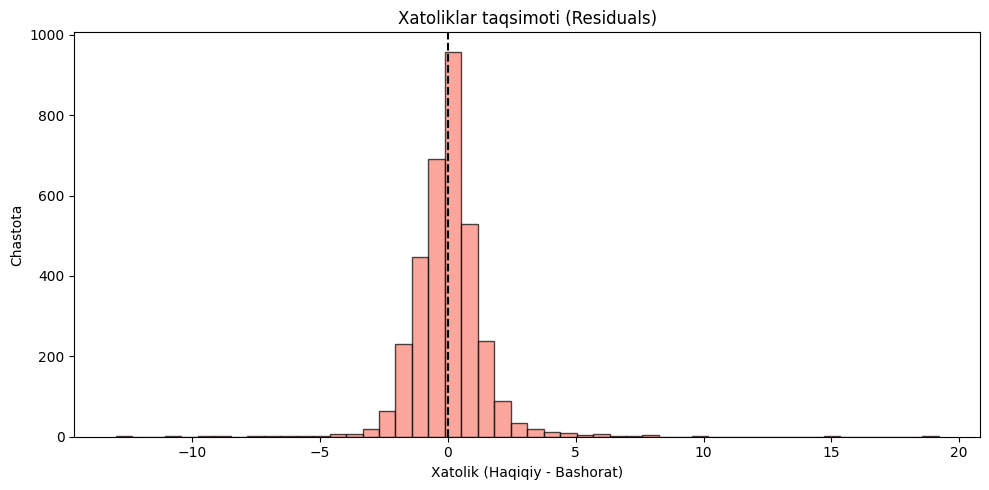

In [15]:
# Xatoliklar taqsimoti
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, color='salmon', edgecolor='black', alpha=0.7)
plt.axvline(0, color='black', linestyle='--', linewidth=1.5)
plt.xlabel('Xatolik (Haqiqiy - Bashorat)')
plt.ylabel('Chastota')
plt.title('Xatoliklar taqsimoti (Residuals)')
plt.tight_layout()
plt.show()

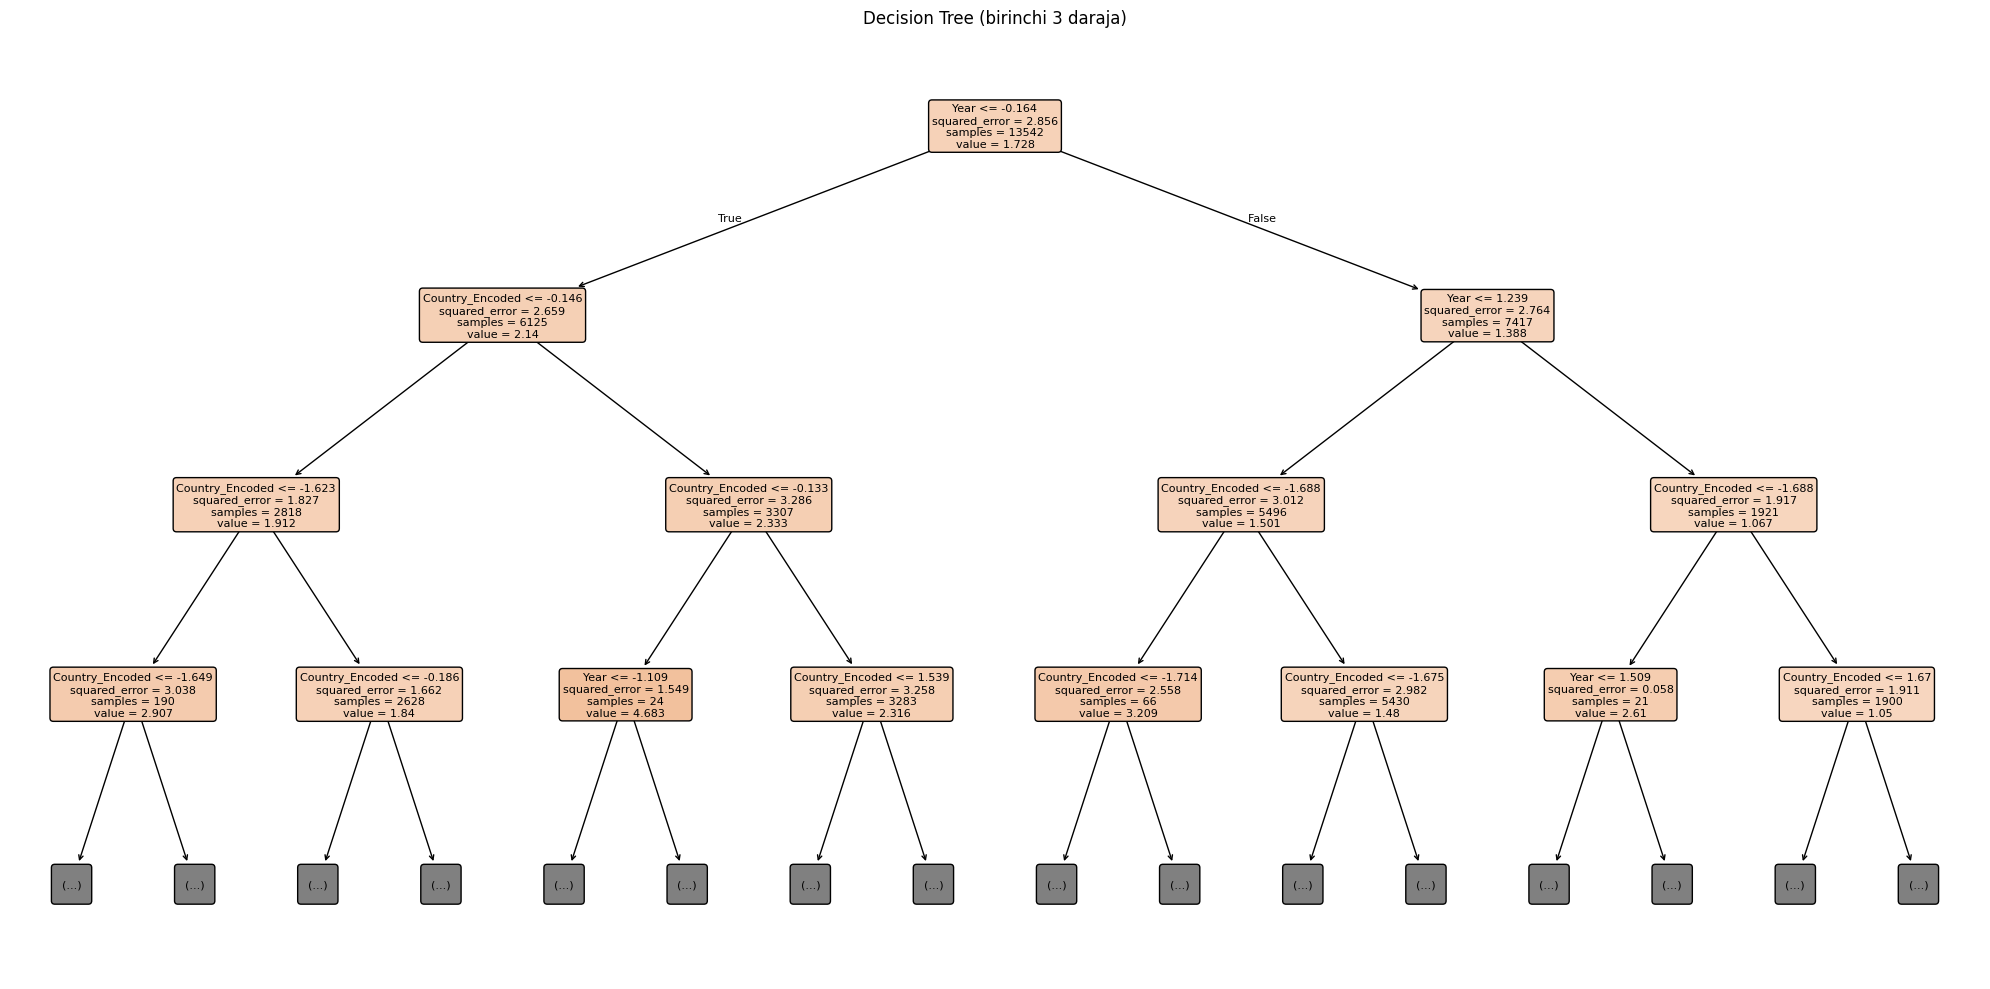

In [16]:
# Decision Tree vizualizatsiyasi (cheklangan chuqurlik bilan)
tree_model = pipeline.named_steps['model']

plt.figure(figsize=(20, 10))
plot_tree(tree_model, max_depth=3, feature_names=['Country_Encoded', 'Year'],
          filled=True, rounded=True, fontsize=8)
plt.title('Decision Tree (birinchi 3 daraja)')
plt.tight_layout()
plt.show()

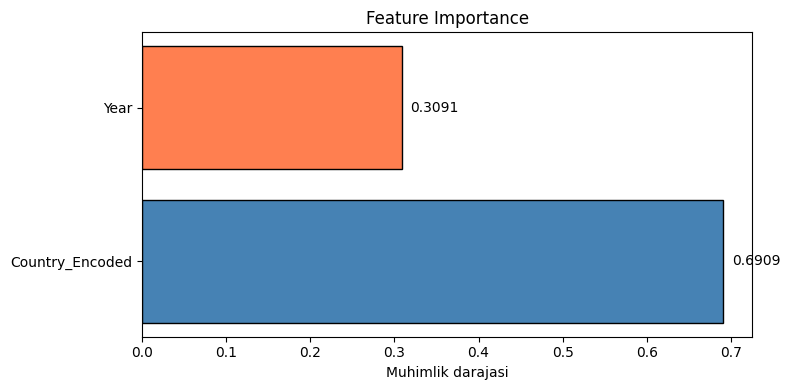

In [17]:
# Feature importance
importances = tree_model.feature_importances_
features = ['Country_Encoded', 'Year']

plt.figure(figsize=(8, 4))
plt.barh(features, importances, color=['steelblue', 'coral'], edgecolor='black')
plt.xlabel('Muhimlik darajasi')
plt.title('Feature Importance')
for i, v in enumerate(importances):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center')
plt.tight_layout()
plt.show()

## Xulosa

1. **Dataset** — 266 ta davlat uchun 1960-2025 yillar orasidagi aholi o'sishi (annual %) ma'lumotlari qayta ishlandi
2. **Preprocessing** — ma'lumotlar wide formatdan long formatga o'tkazildi, bo'sh qiymatlar tozalandi, LabelEncoder qo'llanildi
3. **Pipeline** — SimpleImputer + StandardScaler + DecisionTreeRegressor pipeline yaratildi
4. **Natija** — Model MSE, RMSE, MAE va R2 metrikalari orqali baholandi